
<h1 id="Tutorial-7---Three-way-Branch-Migration-Transitions">Tutorial 7 - Three-way Branch Migration Transitions<a class="anchor-link" href="#Tutorial-7---Three-way-Branch-Migration-Transitions">¶</a></h1><p>This example is similar to Tutorial 1, where we studied the opening and closing of a hairpin ('kissing stem-loop'). This time, we discuss how multistranded complexes are handled. Mainly, we think about what the exact and loose macrostate differences are -- what do they tell us?</p>
<p>Let's start with some basic imports:</p>


In [3]:
from multistrand.objects import *
from multistrand.options import Options, Literals
from multistrand.system import SimSystem

import numpy as np


<h2 id="Macrostates,-complexes,-strands-and-domains.">Macrostates, complexes, strands and domains.<a class="anchor-link" href="#Macrostates,-complexes,-strands-and-domains.">¶</a></h2>



<p>In the following setup, we simulate a three-way branch migration. To study how the branch migration progresses, we define intermediate structures and measure how much time the simulation spents in each of these states. We also estimate the transition probability between each of these states. In the below, we define the initial structure,  in addition to structures with six, twelve and eightteen displaced base-pairs.</p>
<p>We explore two competing approaches by defining exact and the loose macrostates. Note how in the dot-parenthesis notation, which is used to denote secondary structure for our nucleic acids, the asterix is used as a wildcard. In the loose macro states, only eight out of the seventy-two possible base-pairs are defined, and if any state includes at least six of those bounds, then it is in the set of matching states. In contrast, the exact macrostates have no wildcards and only when the simulation reaches that the exact state, a match is recorded.</p>


In [4]:
def setup_options_threewaybm(toehold_seq = "GTGGGT", bm_design = "ACCGCACGTCACTCACCTCG"):

    # the structures below are hard-coded for these lengths
    assert len(toehold_seq)==6
    assert len(bm_design)==20

    toehold = Domain(name="toehold",sequence=toehold_seq,length=6)
    branch_migration = Domain(name="bm", sequence=bm_design, seq_length=20)
    
    substrate = toehold + branch_migration
    incumbent = Strand(name="incumbent",domains=[branch_migration.C])

    incoming = substrate.C

    # start with 6-base toehold fully bound
    start_complex = Complex(strands=[incoming, substrate, incumbent], structure=".(+)(+)")

    initial_structure_dp   = "....................((((((+))))))((((((((((((((((((((+))))))))))))))))))))"
    six_bases_structure_dp = "..............((((((((((((+))))))))))))((((((((((((((+))))))))))))))......"
    six_bases_loose_dp     = "**************((**********+**********))((************+************))******"
    twelve_bases_struc_dp  = "........((((((((((((((((((+))))))))))))))))))((((((((+))))))))............"
    twelve_bases_loose_dp  = "********((*****************+***************))((******+******))************"
    eighteen_structure_dp  = "..((((((((((((((((((((((((+))))))))))))))))))))))))((+)).................."
    eighteen_loose_dp      = "**((**********************+**********************))((+))******************"

    six_bases_complex           = Complex(strands=[incoming,substrate,incumbent], structure=six_bases_structure_dp)
    twelve_bases_complex        = Complex(strands=[incoming,substrate,incumbent], structure=twelve_bases_struc_dp)
    eighteen_bases_complex      = Complex(strands=[incoming,substrate,incumbent], structure=eighteen_structure_dp)
    six_basesloose_complex      = Complex(strands=[incoming,substrate,incumbent], structure=six_bases_loose_dp)
    twelve_basesloose_complex   = Complex(strands=[incoming,substrate,incumbent], structure=twelve_bases_loose_dp)
    eighteen_basesloose_complex = Complex(strands=[incoming,substrate,incumbent], structure=eighteen_loose_dp)

    disassoc_complex            = Complex(strands=[incumbent], structure=".")   # succesful strand displacement
    failed_complex              = Complex(strands=[incoming], structure="..")   # failed strand displacement attempt

    start_sc          = Macrostate("INITIAL", [(start_complex,Literals.count_macrostate,2)])                 # Within distance 2 of the start_complex state.
    six_sc_exact      = Macrostate("SIX_EXACT", [(six_bases_complex,Literals.exact_macrostate,0)])           # the third parameter is ignored; not needed for exact macrostates
    six_sc_loose      = Macrostate("SIX_LOOSE", [(six_basesloose_complex,Literals.loose_macrostate,2)])      # 8 base pairs defined; must have at least 6 to match.
    twelve_sc_exact   = Macrostate("TWELVE_EXACT", [(twelve_bases_complex,Literals.exact_macrostate,0)])
    twelve_sc_loose   = Macrostate("TWELVE_LOOSE", [(twelve_basesloose_complex,Literals.loose_macrostate,2)])
    eighteen_sc_exact = Macrostate("EIGHTEEN_EXACT", [(eighteen_bases_complex,Literals.exact_macrostate,0)])
    eighteen_sc_loose = Macrostate("EIGHTEEN_LOOSE", [(eighteen_basesloose_complex,Literals.loose_macrostate,2)])

    # why bother giving a list of just one macrostate-def tuple?  A Macrostate with a list of multiple tuples give the AND (i.e. intersection) of microstates.

    completed_sc      = StopCondition("stop:COMPLETE", [(disassoc_complex,Literals.dissoc_macrostate,0)])  # incumbent strand fell off
    rejected_sc       = StopCondition("stop:REJECTED", [(failed_complex,Literals.dissoc_macrostate,0)])    # incoming strand fell off

    # join_concentration is not defined, because in this simulation we stop before there's any chance for association steps
    o_exact = Options(simulation_mode="Transition", dangles="Some",
                      num_simulations = 5, simulation_time=.01, temperature=310.15,
                start_state=[start_complex], verbosity=0)
    o_exact.DNA23Metropolis()
    o_exact.stop_conditions = [start_sc, six_sc_exact, twelve_sc_exact, eighteen_sc_exact, completed_sc, rejected_sc]
    o_loose = Options(simulation_mode="Transition", dangles="Some",
                num_simulations = 5, simulation_time=.01, temperature=310.15,
                start_state=[start_complex], verbosity=0)
    o_loose.DNA23Metropolis()

    o_loose.stop_conditions = [start_sc, six_sc_loose, twelve_sc_loose, eighteen_sc_loose, completed_sc, rejected_sc]
    return o_exact, o_loose


<p>Were you able to figure out the topology of the initial state,  <code>initial_structure_dp</code>, in the above? It looks like this:</p>

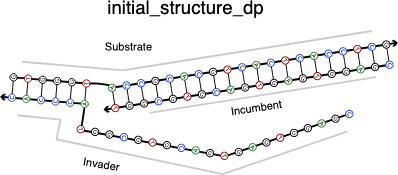

<p>With this in mind, you'll be able to work out the other states, which are specified to have six, twelve and eighteen displaced base-pairs, respectively.</p>
<p>To keep track of the progress of the three-way branch migration, the following helper functions are defined:</p>


In [5]:
# mol will be a list of True/False for which transition macrostates the system has entered
# so in_state(mol) returns True if the system is in at least one of the listed macrostates.
def in_state( mol ): return sum(mol) > 0

# mol is a Boolean descriptor of macrostate occupancy, like mol above.
# a short-hand name for this macrostate (based on the order given in stop_conditions) is provided.
def mol_name(mol):
    charindex = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0'
    names = [charindex[j] for i,j in zip(mol,range(len(mol))) if i]
    if names == []:
        names = charindex[26]
    else:
        names = ",".join(names)
    return names

# t0 and t1 are Boolean descriptors of macrostate occupancy, like mol above.
# here, we provide a printable name for the transition between two macrostate occupancy lists.
def trans_name(t0,t1):
    return mol_name(t0) + ' -> ' + mol_name(t1)

def print_transitions( transition_traj ):
    for t in transition_traj:
        print("%12g : %s" % ( t[0], mol_name(t[1])))

In [6]:
# for each simulation, the transition trajectory reports the tuple (time_entered, which_macrostates_the_system_is_now_in)
def parse_transition_lists( transition_traj_list ):
    transition_dict = {}

    # the mol1 --> mol2 transition times represent (time of entry into mol1) to (time of entry into mol2)
    for transition_traj in transition_traj_list:
        truncated = [i for i in transition_traj if in_state(i[1])]
        tt = truncated # only keep the entry times and mol states for non-trivial mols

        for i in range(len(tt)-1):
            nm = trans_name(tt[i][1],tt[i+1][1])
            if nm in transition_dict:
                transition_dict[nm].append( tt[i+1][0] - tt[i][0] )
            else:
                transition_dict[nm] = [tt[i+1][0] - tt[i][0]]

    return transition_dict

def parse_transition_list( transition_traj_list ):
    return parse_transition_lists( [transition_traj_list] )

    
def print_transition_dict( transition_dict, options = None ):
    k = transition_dict.keys()
    sorted(k) 

    for i in k:
        transition_times = np.array( transition_dict[i] )
        print("{0}: {2:.2e} ({1})".format(i,len(transition_dict[i]),np.mean(transition_times)))
    
    # also print the true names of the macrostates, if an Options object is provided
    charindex = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0'
    if options:
        for i,idx in zip(options.stop_conditions,range(len(options.stop_conditions))):
            print("{0}: {1}".format( i.tag, charindex[idx]))


<p>We are now ready to start the simualtion.</p>


In [7]:
# Could take up to <10s to run

print("--- Running simulations ---")
o_exact,o_loose = setup_options_threewaybm() 

# Try this too... The toehold dissociates much slower.
#o_exact,o_loose = setup_options_threewaybm(bm_design="ACCGCACGTCCACGGTGTCG") 

s=SimSystem(o_exact)
s.start()
print("--- Finished simulations ---")

--- Running simulations ---
--- Finished simulations ---



<p>The following function plots the results for the exact macrostates. Internally, multistrand stores the time and macrostate whenever the simulation enters a macrostate. A transition between macrostates A and B is therefore registered if the simulation, currently in A, enters B before entering any other macrostate.</p>


In [10]:
def print_results( o ):
    print()
    print("--- Analysis of simulations by transitional states ---")
    # print "  Coarse-grained trajectory of simulation #1:"
    # print_transitions(o1.interface.transition_lists[0])
    print("  Transitions from simulation #1:")
    parsedlist = parse_transition_list(o.interface.transition_lists[0])
    print_transition_dict(parsedlist)
    print("  Transitions averaged over all %d simulations:" % o.num_simulations)
    parsedlist = parse_transition_lists(o.interface.transition_lists)
    print_transition_dict(parsedlist,o) # adds names for macrostates

print_results(o_exact)


--- Analysis of simulations by transitional states ---
  Transitions from simulation #1:
A -> A: 1.59e-06 (232)
A -> B: 4.27e-05 (2)
B -> B: 9.77e-06 (30)
B -> A: 1.72e-05 (1)
B -> C: 9.49e-05 (1)
C -> C: 8.78e-06 (24)
C -> D: 2.78e-05 (1)
D -> D: 1.36e-06 (11)
D -> E: 2.06e-06 (1)
  Transitions averaged over all 5 simulations:
A -> A: 1.90e-06 (5574)
A -> B: 5.35e-05 (10)
B -> B: 1.03e-05 (228)
B -> A: 3.85e-05 (7)
B -> C: 2.26e-04 (3)
C -> C: 9.38e-06 (122)
C -> D: 2.23e-05 (4)
D -> D: 1.33e-06 (15)
D -> E: 1.63e-06 (3)
A -> F: 6.06e-06 (2)
D -> C: 1.47e-04 (1)
INITIAL: A
SIX_EXACT: B
TWELVE_EXACT: C
EIGHTEEN_EXACT: D
stop:COMPLETE: E
stop:REJECTED: F



<p>Between state A, the initial state, and state E, indicating succesful migration, and state F, indicating the disocciation of the invading strand from the complex, can you work out in how many simulations the migration was completed?</p>
<p>We now run the same simulation, and report the time spent in the loose macrostates:</p>


In [11]:
s=SimSystem(o_loose)
s.start()
print_results(o_loose)


--- Analysis of simulations by transitional states ---
  Transitions from simulation #1:
A -> A: 1.77e-06 (3238)
A -> B: 4.89e-05 (3)
B -> A: 3.62e-05 (3)
B -> B: 7.28e-06 (38)
A -> F: 8.68e-06 (1)
  Transitions averaged over all 5 simulations:
A -> A: 1.70e-06 (14475)
A -> B: 3.21e-05 (13)
B -> A: 3.75e-05 (12)
B -> B: 7.33e-06 (298)
A -> F: 1.53e-05 (3)
B -> C: 8.69e-05 (1)
C -> C: 6.86e-06 (119)
C -> D: 8.74e-06 (1)
D -> D: 7.54e-06 (3)
D -> E: 2.91e-06 (1)
INITIAL: A
SIX_LOOSE: B
TWELVE_LOOSE: C
EIGHTEEN_LOOSE: D
stop:COMPLETE: E
stop:REJECTED: F



<p>The lesson here is similar to Tutorial 1. When exact macrostates are tracked, not much information is obtained because the system does not spend much time in each exact macrostate. Using a more relaxed macrostate, we are able to track the migration process in greater detail.</p>
